## Assignment 3 - PyTorch version

This is a version of assignment 3 that is made in [PyTorch](https://pytorch.org/) rather than Tensorflow/Keras.

This is for anyone who has been having trouble running tensorflow on their computer (especially if you have an M2 Mac!), or for students who just generally want the experience of working with a different deep learning library! For several years now PyTorch has become the most [commonly used library by researchers](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) in this field.

PyTorch operates at a lower level of abstraction to Keras. Which means we need to write a bit more code to implement and train our model. This may make the code look more complex at first, but actually this is often preferable as it is hiding less about what the code is doing from you and you have more control over how your models are built, trained and represented.

If you want more practice with PyTorch [take a look at their excellent set of tutorials](https://pytorch.org/tutorials/).

- __Extend the model in this notebook into one which maps (X,Y) -> (R,G,B).__
- __Add at least 2 more layers to the network.__
- __Experiment with alternative activation functions and optimizers.__
- __In a paragraph or so, describe how the image we have created differs from a normal image.__

You can find other images to play with [from SciKit Image here](https://scikit-image.org/docs/dev/api/skimage.data.html), but of course you could experiment with using you're own images. For that you might want to use the [Pillow](https://pillow.readthedocs.io/en/stable/) package which has some [handy functions for loading and manipulating images](https://pillow.readthedocs.io/en/stable/reference/Image.html).

This shouldn't take you longer than an afternoon! __This will be handed in at the end of the module__ so once you have something working it would be _much appreciated_ if you go back over your code and tidy it up, maybe add comments to describe what is happening in the code.

Here are some more lovely examples from [David Ha](https://twitter.com/hardmaru):

![David Ha bw](./images/hardmaru_color.png)

---

If you like this work you could take some ideas explored by David Ha in his blog posts on this topic and re-implement them, or take them further for your final project. I think there is a lot of potential for creating really interesting images and even interesting drawing tools!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import skimage
import random
from skimage.transform import resize
import matplotlib.pyplot as plt

Set the device for your machine.

For Mac M1/M2 this should say device should be `mps`.

For a machine with an NVIDIA GPU device should be `cuda`.

To run on the CPU of any other machine, device should be `cpu`.

In [2]:
# device = 'cuda'
# device = 'mps' 
device = 'cpu'

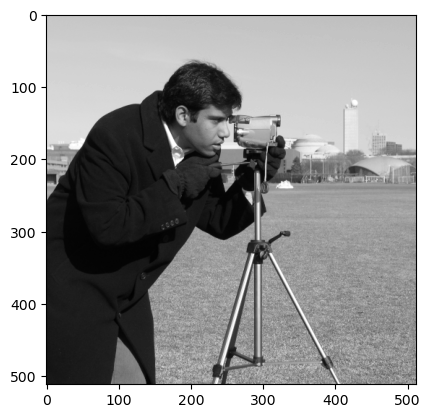

In [3]:
#Get image from skimage
img = skimage.data.camera()
smaller_img = resize(img, (64, 64)) # Resize it just to make things quicker
plt.imshow(img, cmap='gray')

In [4]:
#Our function that gets a grid of coordinates
def get_mgrid(sidelen):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    width = np.linspace(-1, 1, sidelen)
    height = np.linspace(-1, 1, sidelen)
    mgrid = np.stack(np.meshgrid(width, height), axis=-1)
    mgrid = np.reshape(mgrid, [-1, 2])
    return mgrid

Defining the variables we will be using as our training dataset.

In [5]:
image_side_length = smaller_img.shape[0]
X = get_mgrid(image_side_length)      # Inputs
X = np.float32(X)

#Convert input array to torch tensor
X_torch_tensor = torch.tensor(X, device=device)

y = np.reshape(smaller_img, [-1, 1])  # Outputs
y = np.float32(y)

#convert output array to torch tensor
y_torch_tensor = torch.tensor(y, device=device)

#Get the total number of coordinates 
num_coords = X_torch_tensor.shape[0]

Lets check to see our data tensor is running on the right device.

For Mac M1/M2 this should say `mps:0`.

For CPU this should say `cpu`.

For a machine with an NVIDIA GPU this should say `cuda`.

In [6]:
print(X_torch_tensor.device)

cpu


Here we define our model. Our network is a class that inherits from the base model in tensorflow `nn.Module`.

`def __init__(self):` Is where the constructor is defined, this is the function that gets called when our network is first **initialised** here we tell it what the layers are and the parameters that we want to keep track of.

`def forward(self, x):` is where we define the forward pass of the model. This is what we want the model to do with every input data example and define what layers (and activation functions) are ran, and what the output is that our model generates.

In [7]:
class CPPN(nn.Module):
    def __init__(self):
      super(CPPN, self).__init__()

      # First fully connected layer
      self.fc1 = nn.Linear(2, 16)
      # Second fully connected layer
      self.fc2 = nn.Linear(16, 32)
      # Third fully connected layer
      self.fc3 = nn.Linear(32, 1)     
    
    # x represents our data
    def forward(self, x):
        # Pass through first fully connected layer
        x = self.fc1(x)
        # Relu activation function
        x = F.relu(x)
        
        # Pass through second fully connected layer
        x = self.fc2(x)
        # Relu activation function
        x = F.relu(x)

        # Pass through third fully connected layer
        x = self.fc3(x)
        # Sigmoid activation function
        x = F.sigmoid(x)

        # Return our output
        return x

This is the code where we create our model, we create one version of our network based on our `CPPN` class. We also need to define the loss function we are using `criterion` and what `optimiser` we are using for updating the weights of the network.

In [8]:
num_epochs = 8
batch_size = 1

cppn = CPPN()
cppn.to(device)
cppn.requires_grad_()

optimiser = torch.optim.SGD(cppn.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

This is wheere we train the model. We have a for loop that tells us how many times we want to process data during training. This depends on the size of the data `num_coords`, the number of epochs (cycles through the data) `num_epochs`, and the batch size `batch_size`.

During training we process one batch at a time, our input batch is the `input_batch` variable (which is our batch of coordinates), our output batch is the `true_pixel_values`. 

We use our network model to get approximations of the pixel values `approx_pixel_values` based on the input coordinates, and compare that to our true pixel values using our loss function critera. Once we have our the value of our loss for that batch `loss`, we call `loss.backward()` to backpropagate the error through the network model. We then call `optimiser.step()` to update the weights of our neural network model. 

We do this repeatedly until we have completed the number of cycles through our datset `num_epochs`.

In [9]:
coord_indexes = list(range(0, num_coords))
for i in range( int((num_epochs * num_coords) / batch_size) ):
    optimiser.zero_grad()
    cppn.zero_grad()

    # Get batch of data
    batch_indexes = torch.tensor(np.array(random.sample(coord_indexes, batch_size)))
    input_batch = X_torch_tensor[batch_indexes]
    true_pixel_values = y_torch_tensor[batch_indexes]

    # Process data with model
    approx_pixel_values = cppn(input_batch)

    # Calculate loss function
    loss = criterion(true_pixel_values, approx_pixel_values)
    
    if i % 1000 == 0:
        print(f'step {i}, loss {loss:.3f}')
    
    #Update model
    loss.backward()
    optimiser.step()


step 0, loss 0.018


/opt/miniconda3/envs/aim_pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


step 1000, loss 0.123
step 2000, loss 0.149
step 3000, loss 0.120
step 4000, loss 0.002
step 5000, loss 0.019
step 6000, loss 0.070
step 7000, loss 0.009
step 8000, loss 0.005
step 9000, loss 0.048
step 10000, loss 0.013
step 11000, loss 0.032
step 12000, loss 0.011
step 13000, loss 0.001
step 14000, loss 0.050
step 15000, loss 0.010
step 16000, loss 0.003
step 17000, loss 0.001
step 18000, loss 0.016
step 19000, loss 0.003
step 20000, loss 0.174
step 21000, loss 0.007
step 22000, loss 0.006
step 23000, loss 0.039
step 24000, loss 0.034
step 25000, loss 0.007
step 26000, loss 0.002
step 27000, loss 0.003
step 28000, loss 0.000
step 29000, loss 0.014
step 30000, loss 0.021
step 31000, loss 0.002
step 32000, loss 0.001


Now lets process the whole image again with the trained model.

In [10]:
with torch.no_grad():
    prediction = cppn(X_torch_tensor)

Now lets visualise the results!

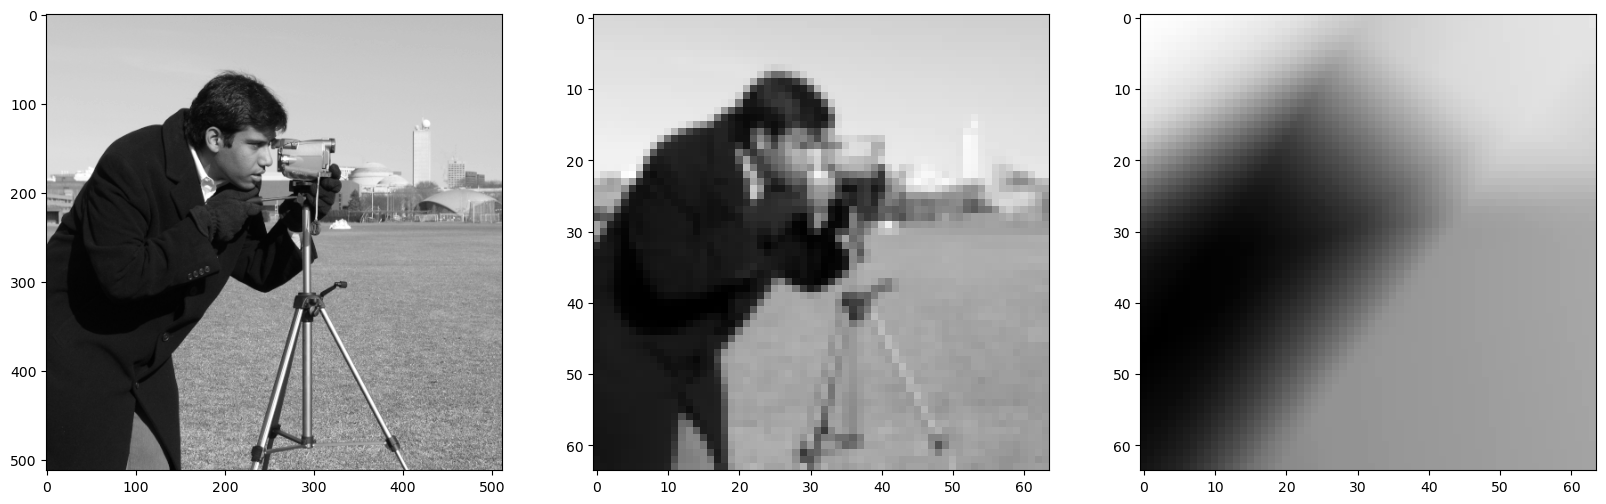

In [11]:
# Reshape it from 1D to 2D
reconstructed_img = np.reshape(prediction.cpu(), (64, 64))
# Scale the values from [0,1] to [0, 255]
reconstructed_img *= 255
# Convert the tensor into a numpy array, and cast the type into a uint8.
reconstructed_img = reconstructed_img.numpy().astype(np.uint8)
# Look at our creation next to the original!
fig, axes_array = plt.subplots(1,3, figsize=(20,10))
axes_array[0].imshow(img, cmap='gray')
axes_array[1].imshow(smaller_img, cmap='gray')
axes_array[2].imshow(reconstructed_img, cmap='gray')
plt.show()